# Transformers model

#### Authors: Brendan and Fernando

This notebook guides you through the process of designing the Transformer model and selecting appropriate hyperparameters. The steps include:

+ Importing the Data: Loading the necessary datasets.
+  Designing a Preliminary Model: Creating an initial model and evaluating its performance on three different pre-processed window sizes. Choosing the best-performing one to proceed with.
+ Hyperparameter Tuning: Adjusting hyperparameters, including testing different configurations of Transformer blocks for optimization.
+ Model evaluation: Evaluate the general performance of the models and compare binary vs multiclass classification.

In [1]:
#set up the workspace, environment and load libraries
#----------------------------------------------------
#Set sytem version
import sys
assert sys.version_info >= (3, 7)

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#import sklearn
import sklearn
assert sklearn.__version__>="0.20"

#import tensorflow
from packaging import version
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")

#import libraries
import pandas as pd
import numpy as np
import pandas as pd
import G9_functions

#Figure setup
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Load the Datafiles

In this segment, we load three distinct data files linked to various window splits. Following that, we assign a label of 1 to indicate the presence of snoring and 0 to denote its absence. Additionally, it's crucial to obtain the truncated or sequence length of the data frame to generate the numpy array before feeding it into the model.

In [33]:
#load the three different frame types
padded_trunc_mfcc_50_path="Data/padded_truncated_mfcc_50ms.csv" #soundfiles split to 50ms
padded_trunc_mfcc_100_path="Data/padded_truncated_mfcc_100ms.csv" #soundfiles split to 100ms frames
padded_trunc_mfcc_500_path="Data/padded_truncated_mfcc_500ms.csv" #soundfiles split to 500ms frames

#Read into dataframes
padded_trunc_mfcc_50 = pd.read_csv(padded_trunc_mfcc_50_path)
padded_trunc_mfcc_100 =  pd.read_csv(padded_trunc_mfcc_100_path)
padded_trunc_mfcc_500 =  pd.read_csv(padded_trunc_mfcc_500_path)

#collect truncation lengths
truncation_length_dic={ "padded_trunc_mfcc_50":padded_trunc_mfcc_50.iloc[0, -1],
                       "padded_trunc_mfcc_100":padded_trunc_mfcc_100.iloc[0, -1],
                       "padded_trunc_mfcc_500":padded_trunc_mfcc_500.iloc[0, -1]
                      }

In [35]:
# Define the mapping dictionary
label_mapping = {'S1': 1,'S2': 2,'S3': 3, 'N': 0}

# Replace values in the 'label' column using the mapping dictionary
padded_trunc_mfcc_50['label'] = padded_trunc_mfcc_50['label'].replace(label_mapping)
padded_trunc_mfcc_100['label'] = padded_trunc_mfcc_100['label'].replace(label_mapping)
padded_trunc_mfcc_500['label'] = padded_trunc_mfcc_500['label'].replace(label_mapping)

### Prepare Data for transformer

In [36]:
def prepare_X_y_sequences_mfcc_data(df,num_mfccs,truncated_length):
    mfcc_columns = [f'mfcc_{i}' for i in range(1, num_mfccs+1)] #list of the MFCC values
    X = np.array([df[mfcc_column].apply(eval).tolist() for mfcc_column in mfcc_columns]) #merge the MFCC for each instance to a single list e.g. [mfcc1,mfcc2,...,mfcc13]time,
    X = X.transpose(1, 0, 2)  # Transpose to (13, number_of_samples, reference_length)
    X = X.reshape(-1, truncated_length, 13)
    y = df['label']
    return X, y

In [37]:
X_50,y_50 = prepare_X_y_sequences_mfcc_data(padded_trunc_mfcc_50,13,truncation_length_dic.get("padded_trunc_mfcc_50"))

X_100,y_100 = prepare_X_y_sequences_mfcc_data(padded_trunc_mfcc_100,13,truncation_length_dic.get("padded_trunc_mfcc_100"))

X_500,y_500 = prepare_X_y_sequences_mfcc_data(padded_trunc_mfcc_500,13,truncation_length_dic.get("padded_trunc_mfcc_500"))

### Test Train Split

In this section we split the data into a testing and training data. The function `train_test_val_datasets_mfcc_sequences` is designed to standardize the data based on the training split if the user wishes and also perform stratified sampling. The train, validation and test split is 65%, 15% and 20% respectively.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Function to create test, train, val datasets
def train_test_val_datasets_mfcc_sequences(X, y, test_size=0.2, val_size=0.15, stratify=True, random_state=False, scale=False, num_mfccs=False):
    
    val_size = 0.15/ (1-test_size) #
    
    if stratify is True:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y,shuffle=True,random_state=random_state)
        if scale is True:
            
            #Obtain shapes
            X_train_shape=X_train.shape
            X_test_shape=X_test.shape
            
            #scale the MFCCs on the training set
            scaler = StandardScaler()
            scaler.fit(X_train.reshape(-1,num_mfccs))
            X_train = scaler.transform(X_train.reshape(-1,num_mfccs))
            X_test=scaler.transform(X_test.reshape(-1,num_mfccs))
            
            #reshape back into sequences of MFCCS
            X_train = X_train.reshape(X_train_shape)
            X_test = X_test.reshape(X_test_shape)
            
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train,shuffle=True, random_state=random_state)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,shuffle=True,random_state=random_state)
        if scale is True:
            
            #Obtain shapes
            X_train_shape=X_train.shape
            X_test_shape=X_train.shape
            
            #scale the MFCCs on the training set
            scaler = StandardScaler()
            scaler.fit(X_train.reshape(-1,num_mfccs))
            X_train = scaler.transform(X_train.reshape(-1,num_mfccs))
            X_test=scaler.transform(X_test.reshape(-1,num_mfccs))
            
            #reshape back into sequences of MFCCS
            X_train = X_train.reshape(X_train_shape)
            X_test = X_test.reshape(X_test_shape)
            
        
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size,shuffle=True, random_state=random_state)
    return X_train, y_train, X_val, y_val, X_test, y_test
    

In [39]:
X_train_50, y_train_50, X_val_50, y_val_50, X_test_50, y_test_50 = train_test_val_datasets_mfcc_sequences(X=X_50, y=y_50, test_size=0.2, val_size=0.15,stratify=True,random_state=False,scale=True, num_mfccs=13)

X_train_100, y_train_100, X_val_100, y_val_100, X_test_100, y_test_100 =train_test_val_datasets_mfcc_sequences(X=X_100,y=y_100,test_size=0.2,val_size=0.15,stratify=True,random_state=False, scale=True,num_mfccs=13)

X_train_500, y_train_500, X_val_500, y_val_500, X_test_500, y_test_500 = train_test_val_datasets_mfcc_sequences(X=X_500,y=y_500,test_size=0.2,val_size=0.15,stratify=True,random_state=False, scale=True,num_mfccs=13)

In [54]:
# Create new binary labels objects by copying the original labels
y_train_50_B = np.copy(y_train_50)
y_val_50_B = np.copy(y_val_50)
y_test_50_B = np.copy(y_test_50)
y_train_100_B = np.copy(y_train_100)
y_val_100_B = np.copy(y_val_100)
y_test_100_B = np.copy(y_test_100)
y_train_500_B = np.copy(y_train_500)
y_val_500_B = np.copy(y_val_500)
y_test_500_B = np.copy(y_test_500)

# Convert classes to binary (1 for positive class, 0 for others)
y_train_50_B[y_train_50_B > 0] = 1
y_val_50_B[y_val_50_B > 0] = 1
y_test_50_B[y_test_50_B > 0] = 1
y_train_100_B[y_train_100_B > 0] = 1
y_val_100_B[y_val_100_B > 0] = 1
y_test_100_B[y_test_100_B > 0] = 1
y_train_500_B[y_train_500_B > 0] = 1
y_val_500_B[y_val_500_B > 0] = 1
y_test_500_B[y_test_500_B > 0] = 1

# Transformer model

In this section we set up a transformer model based on the design proposed by (Vaswani et al. 2017). There are some modifications as this problem is different to natural language processing and the outputs are quite simple being binary or one of four classes (No Snoring, S1, S2, S3). So for this problem an encoder-decoder like architecture is not necessarily required, because the outputs are simple. However we would like to use the self attention block to undestant distance wise patterns in the sequneces whcih are associated with the classes.

This Transformer model contains the following architecture:
+ A positonal encoding layer which will encode the positon of the MFCC values within the sequence. The positonal encodings will be fixed and based on the sin and cosine functions at different frequencies. This means the number of MFCC values must be cut down to 12 to ensure that the embeding size is even.
+ An addative layer to add the inputs and positional encodings.
+ A Multi-Head attention layer
+ An addative layer adding the outputs of the A Multi-Head attention layer and the  positional encodings+ initial inputs addative layer
+ A normalisation layer
+ A Feed forward block with 2 Dense layers with 26 and 12 nuerons respectively
+ An addative layer adding the outputs of the attentiona addative layer and the feed-forwards output layer.
+ A normalisation layer
+ A global pooling layer to reduce the  sequence dimensionality. This is particularly applicable due to the potentially varying sequnece lengths.

#### Part 1: Define a simple Transformer architecture

In this code block a class is created to create the positonal encodings layer using Sine/Cosine positional encodings.

In [40]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super(PositionalEncoding, self).__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length), 2 * np.arange(embed_size // 2))
        pos_encodings = np.empty((1, max_length, embed_size))
        pos_encodings[0, :, ::2] = np.sin(p / 10000 ** (i / embed_size)).T
        pos_encodings[0, :, 1::2] = np.cos(p / 10000 ** (i / embed_size)).T
        
        # Masked positions set to zeros
        self.pos_encodings = tf.constant(pos_encodings.astype(self.dtype))
        self.supports_masking = True
        
    def call(self, inputs, mask=None):
        batch_max_length = tf.shape(inputs)[1]
        pos_encodings = self.pos_encodings[:, :batch_max_length, :]
        outputs = inputs + pos_encodings
        
        # Apply mask if provided
        if mask is not None:
            outputs *= tf.expand_dims(1 - mask, axis=-1)
        
        return outputs
        

This code block is a function to create a a transformer block as described above.

In [42]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the Transformer model for the mfcc_sequences
def create_transformer_model_mfcc_sequences(max_seq_length, num_classes, num_mfcc_features):
    inputs = keras.Input(shape=(max_seq_length, num_mfcc_features))  # Input shape for MFCCs
    
    #postional encodings
    positional_embed_layer = PositionalEncoding(max_seq_length,num_mfcc_features)(inputs)
    
    # Multi-Head Self-Attention layer
    attention = layers.MultiHeadAttention(num_heads=8, key_dim=12, value_dim=12, dropout=0.1)(positional_embed_layer, positional_embed_layer)
    
    # Add and Layer Normalization
    attention = layers.Add()([positional_embed_layer, attention])
    attention = layers.LayerNormalization(epsilon=1e-6)(attention)
    
    # Feed-Forward layer
    ff_hidden = layers.Dense(24, activation="relu")(attention)
    ff_output = layers.Dense(12)(ff_hidden)
    
    # Add and Layer Normalization
    transformer_output = layers.Add()([attention, ff_output])
    transformer_output = layers.LayerNormalization(epsilon=1e-6)(transformer_output)
    
    # Global Average Pooling to reduce sequence length
    avg_pooling = layers.GlobalAveragePooling1D()(transformer_output)
    
    # Output layer for classification
    if num_classes == 2:
        outputs = layers.Dense(1, activation="sigmoid")(avg_pooling)
    
    else:
        outputs = layers.Dense(num_classes, activation="softmax")(avg_pooling)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

#### Part 2: Compare the time splits

In [56]:
#Multiclass Models
transformer_model_50_MC = create_transformer_model_mfcc_sequences(truncation_length_dic.get("padded_trunc_mfcc_50"), 4,12)
transformer_model_100_MC = create_transformer_model_mfcc_sequences(truncation_length_dic.get("padded_trunc_mfcc_100"), 4,12)
transformer_model_500_MC = create_transformer_model_mfcc_sequences(truncation_length_dic.get("padded_trunc_mfcc_500"), 4,12)

#Binary Models
transformer_model_50_B = create_transformer_model_mfcc_sequences(truncation_length_dic.get("padded_trunc_mfcc_50"), 2,12)
transformer_model_100_B = create_transformer_model_mfcc_sequences(truncation_length_dic.get("padded_trunc_mfcc_100"), 2,12)
transformer_model_500_B = create_transformer_model_mfcc_sequences(truncation_length_dic.get("padded_trunc_mfcc_500"), 2,12)

In [57]:
# Compile the models
transformer_model_50_MC.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
transformer_model_100_MC.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
transformer_model_500_MC.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
transformer_model_50_B.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
transformer_model_100_B.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
transformer_model_500_B.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [58]:
class PrintEpochLossCallback(tf.keras.callbacks.Callback):
    def __init__(self, n=5):
        super().__init__()
        self.n = n
        self.best_val_loss = float('inf')  # Initialize best_val_loss with positive infinity
        self.best_epoch = 0


    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.n == 0:
            
 
            print("Epoch", epoch, "loss:", round(logs["loss"], 5), "val_loss:", round(logs["val_loss"], 5),
                  "acc:", round(logs["accuracy"], 5), "val_acc:", round(logs["val_accuracy"], 5))
    
        # Check if the current epoch has the best validation loss
        if logs["val_loss"] < self.best_val_loss:
            self.best_val_loss = logs["val_loss"]
            self.best_epoch = epoch
    
    
    def on_train_end(self, logs=None):
        print("Model finished training")
        print("Best epoch:", self.best_epoch, "with val_loss:", round(self.best_val_loss, 5))

# Assuming X_val and y_val are your validation data
custom_callback = PrintEpochLossCallback(n=10)

In [59]:
# Define the number of epochs and batch size
epochs = 10
batch_size = 32

# Fit/Train the MC models
history_50_MC = transformer_model_50_MC.fit(X_train_50[:,:,:-1], y_train_50,epochs=epochs,batch_size=batch_size,
                                      validation_data=(X_val_50[:,:,:-1], y_val_50),verbose=0,callbacks=[custom_callback])

history_100_MC = transformer_model_100_MC.fit(X_train_100[:,:,:-1], y_train_100,epochs=epochs,batch_size=batch_size,
                                        validation_data=(X_val_100[:,:,:-1], y_val_100),verbose=0,callbacks=[custom_callback])

history_500_MC = transformer_model_500_MC.fit(X_train_500[:,:,:-1], y_train_500,epochs=epochs,batch_size=batch_size,
                                        validation_data=(X_val_500[:,:,:-1], y_val_500),verbose=0,callbacks=[custom_callback])


# Fit/Train the Binary models
history_50_B = transformer_model_50_B.fit(X_train_50[:,:,:-1], y_train_50_B,epochs=epochs,batch_size=batch_size,
                                      validation_data=(X_val_50[:,:,:-1], y_val_50_B),verbose=0,callbacks=[custom_callback])

history_100_B = transformer_model_100_B.fit(X_train_100[:,:,:-1], y_train_100_B,epochs=epochs,batch_size=batch_size,
                                        validation_data=(X_val_100[:,:,:-1], y_val_100_B),verbose=0,callbacks=[custom_callback])

history_500_B = transformer_model_500_B.fit(X_train_500[:,:,:-1], y_train_500_B,epochs=epochs,batch_size=batch_size,
                                        validation_data=(X_val_500[:,:,:-1], y_val_500_B),verbose=0,callbacks=[custom_callback])


Epoch 0 loss: 0.45049 val_loss: 0.33606 acc: 0.82556 val_acc: 0.86838
Model finished training
Best epoch: 8 with val_loss: 0.16031
Epoch 0 loss: 0.41865 val_loss: 0.31436 acc: 0.81554 val_acc: 0.859
Model finished training
Best epoch: 8 with val_loss: 0.16031
Epoch 0 loss: 0.33608 val_loss: 0.24652 acc: 0.87293 val_acc: 0.8913
Model finished training
Best epoch: 8 with val_loss: 0.13633
Epoch 0 loss: 0.30193 val_loss: 0.21531 acc: 0.86844 val_acc: 0.90762
Model finished training
Best epoch: 8 with val_loss: 0.11419
Epoch 0 loss: 0.28997 val_loss: 0.184 acc: 0.86363 val_acc: 0.92169
Model finished training
Best epoch: 8 with val_loss: 0.11419
Epoch 0 loss: 0.23495 val_loss: 0.17196 acc: 0.89994 val_acc: 0.93662
Model finished training
Best epoch: 8 with val_loss: 0.10296


### Learning Curves

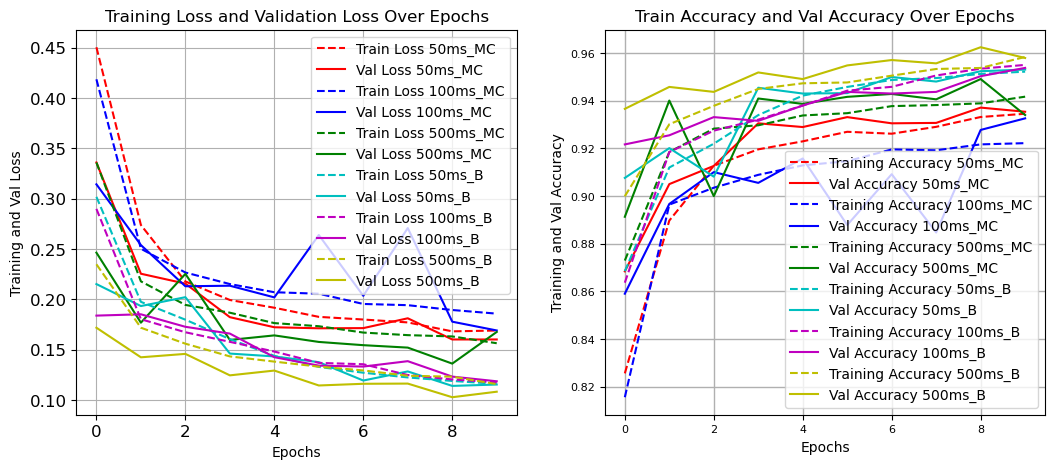

<Figure size 640x480 with 0 Axes>

In [121]:
history_dic={'50ms_MC':history_50_MC,
             '100ms_MC':history_100_MC,
             '500ms_MC':history_500_MC,
             '50ms_B':history_50_B,
             '100ms_B':history_100_B,
             '500ms_B':history_500_B}
G9_functions.plot_learning_curves(history_dic)
plt.savefig("Learning_curves_Transformer_Model.png")

The learning curves show that the models show limited evidence of overfitting after 10 epochs, with the training and vlaidation loss being resonaly close. The 50ms windowed data takes longer to warm up, which is expected as the sequences are 10x longer than the 500ms model. The nina The models using the 50ms and 500ms window sizes appear to be the best for the transformer architecture.

### Accuracy and F1-Score comparison

In [62]:
#Predict the results of the multi-class models
#50ms model
y_proba_test_50_MC = transformer_model_50_MC.predict(X_test_50[:,:,:-1])
y_pred_test_50_MC =y_proba_test_50_MC.argmax(axis=-1)
#100ms model
y_proba_test_100_MC = transformer_model_100_MC.predict(X_test_100[:,:,:-1])
y_pred_test_100_MC =y_proba_test_100_MC.argmax(axis=-1)
#500ms model
y_proba_test_500_MC = transformer_model_500_MC.predict(X_test_500[:,:,:-1])
y_pred_test_500_MC =y_proba_test_500_MC.argmax(axis=-1)


#Predict the results for the binary models
threshold=0.5
#50ms model
y_proba_test_50_B = transformer_model_50_B.predict(X_test_50[:,:,:-1])
y_pred_test_50_B =(y_proba_test_50_B >= threshold).astype(int)
#100ms model
y_proba_test_100_B = transformer_model_100_B.predict(X_test_100[:,:,:-1])
y_pred_test_100_B =(y_proba_test_100_B >= threshold).astype(int)
#500ms model
y_proba_test_500_B = transformer_model_500_B.predict(X_test_500[:,:,:-1])
y_pred_test_500_B =(y_proba_test_500_B >= threshold).astype(int)

240/240 [==============================] - 1s 2ms/step


In [63]:
from sklearn.metrics import accuracy_score, f1_score


# Calculate accuracy and F1 scores for multi-class models
accuracy_50_MC = accuracy_score(y_test_50, y_pred_test_50_MC)
f1_50_MC = f1_score(y_test_50, y_pred_test_50_MC, average='weighted')

accuracy_100_MC = accuracy_score(y_test_100, y_pred_test_100_MC)
f1_100_MC = f1_score(y_test_100, y_pred_test_100_MC, average='weighted')

accuracy_500_MC = accuracy_score(y_test_500, y_pred_test_500_MC)
f1_500_MC = f1_score(y_test_500, y_pred_test_500_MC, average='weighted')

# Calculate accuracy and F1 scores for binary models
accuracy_50_B = accuracy_score(y_test_50_B, y_pred_test_50_B)
f1_50_B = f1_score(y_test_50_B, y_pred_test_50_B)

accuracy_100_B = accuracy_score(y_test_100_B, y_pred_test_100_B)
f1_100_B = f1_score(y_test_100_B, y_pred_test_100_B)

accuracy_500_B = accuracy_score(y_test_500_B, y_pred_test_500_B)
f1_500_B = f1_score(y_test_500_B, y_pred_test_500_B)

# Create a table to display the results
data = {
    "Model": ["50ms Multi-Class", "100ms Multi-Class", "500ms Multi-Class",
              "50ms Binary", "100ms Binary", "500ms Binary"],
    "Accuracy": [accuracy_50_MC, accuracy_100_MC, accuracy_500_MC,
                 accuracy_50_B, accuracy_100_B, accuracy_500_B],
    "F1 Score": [f1_50_MC, f1_100_MC, f1_500_MC,
                 f1_50_B, f1_100_B, f1_500_B]
}

results_df = pd.DataFrame(data)
print(results_df)

               Model  Accuracy  F1 Score
0   50ms Multi-Class  0.936711  0.935418
1  100ms Multi-Class  0.933715  0.930623
2  500ms Multi-Class  0.924600  0.921764
3        50ms Binary  0.953119  0.954774
4       100ms Binary  0.960281  0.961965
5       500ms Binary  0.957416  0.959565


Comparing the models it is apparent that the 100ms Binary model has the best accuracy and weighted F1-score out of the models, when predicitng the test data. The Binary models outperform the multi-class models by ~3% in both accuracy and F1-score.

In [108]:
history_data = []
for model, history in history_dic.items():
    for epoch in range(len(history.history['loss'])):
        history_data.append({
            'Model': model,
            'Epochs': epoch + 1,
            'Loss': history.history['loss'][epoch],
            'Accuracy': history.history['accuracy'][epoch],
            'Val_Loss': history.history['val_loss'][epoch],
            'Val_Accuracy': history.history['val_accuracy'][epoch]
        })
        
history_df = pd.DataFrame(history_data)

csv_file_path = 'Transformer_history_data.csv'

# Export the DataFrame to a CSV file
history_df.to_csv(csv_file_path, index=False)

#Export Transformer results to dictionary
results_df.to_csv('Transformer_Acc_F1.csv',index=True)

## Hyperparameter Tuning

This section will attempt to tune the hyperparameters for the simple transformer model architecture. This will be acheived using `keras_tuner`.

The hyperparameter selection process will be done on the best model which is the 100ms Binary model.

In this model we will search for which of these hyperparameters is optimal;
+ if  multiple transofrmer blocks are preferable to a single block
+ The number of hidden layers in the transformer block
+ The learning rate
+ The dropout rates for both the hidden layers and multi-head attention layer, but seperately.
+ The activation type for the hidden layers out of relu, leaky relu and swish.


In [94]:
from keras_tuner.tuners import Hyperband
from keras_tuner.engine.hyperparameters import HyperParameters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
    max_seq_length =62 #sequence length for 100ms windowed dataset
    num_classes=2 #binary classification (snoring vs non-snoring(
    num_mfcc_features=12 #12 MFCC features
 
    inputs = keras.Input(shape=(max_seq_length, num_mfcc_features))  # Input shape for MFCCs
    
    #postional encodings
    positional_embed_layer = PositionalEncoding(max_seq_length,num_mfcc_features)(inputs)
    
    
    # Hyperparameters to tune
    num_transformer_layers = hp.Int('num_transformer_layers', min_value=1, max_value=2, step=1) #number of self attention blocks
    num_ff_hidden_layers = hp.Int('num_ff_hidden_layers', min_value=1, max_value=2, step=2) #number of hidden layers in each self-attention blocks
    num_heads = hp.Int('num_heads', min_value=4, max_value=8, step=2) #number of heads on the multi-head attention layer
    hidden_units = hp.Int('hidden_units', min_value=24, max_value=48, step=12) #hidden units for each hidden later in the feedforward block
    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='LOG', default=1e-3) #learning rates
    dropout_rate_tf = hp.Float('dropout_rate_tf',min_value=0.1, max_value=0.5, step=0.1) #multi-head attention dropout
    dropout_rate_ff = hp.Float('dropout_rate_ff',min_value=0.1, max_value=0.5, step=0.1) #feedforward dropout
    activation = hp.Choice('activation', values=['relu', 'leaky_relu', 'swish']) #activation types for the feedforward layer
    
    #initialisae the input tensor for the first attention block
    attention_output = positional_embed_layer 
    
    #loop to create N self attention blocks
    for _ in range(num_transformer_layers):
        #self attention layer
        attention = layers.MultiHeadAttention(num_heads=num_heads,
                                              key_dim=num_mfcc_features,
                                              value_dim=num_mfcc_features,
                                              dropout=dropout_rate_tf)(attention_output, attention_output)
        #Additional layer 
        attention_output = layers.Add()([ attention_output,attention])
        #normalisation layer
        attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)
        
        #loop to create N hidden layers in the feedforward network
        for _ in range(num_ff_hidden_layers):
            #dense hidden layer
            ff_hidden = layers.Dense(hidden_units,kernel_initializer='he_normal', activation=None,use_bias=False)(attention_output)
            #Batch normilsation
            ff_hidden = layers.BatchNormalization()(ff_hidden)  # Batch normalization layer
            
            # activation after batch normalization
            if activation == 'relu':
                ff_hidden = layers.Activation("relu")(ff_hidden)
            elif activation == 'leaky_relu':
                ff_hidden = layers.LeakyReLU(alpha=0.2)(ff_hidden)
            elif activation == 'swish':
                ff_hidden = layers.Activation("swish")(ff_hidden)
            ff_hidden = layers.Dropout(dropout_rate_ff)(ff_hidden)
            
        #final output layer
        ff_output = layers.Dense(num_mfcc_features)(ff_hidden)
        #addative layer to add the attention output with the final feed forward output
        attention_output = layers.Add()([attention_output, ff_output])
        #layer normalisation layer
        attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)
    

    # Global Average Pooling to reduce sequence length
    avg_pooling = layers.GlobalAveragePooling1D()(attention_output)
    
    # Output layer for classification 
    if num_classes == 2:
        #if Binary use sigmoid activation
        outputs = layers.Dense(1, activation="sigmoid")(avg_pooling)
    else:
         #if Multiclass use softmax activation
        outputs = layers.Dense(num_classes, activation="softmax")(avg_pooling)
    
    #Build the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    #Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),loss='binary_crossentropy' if num_classes == 2 else 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

#-----------------------------------------------------------------------
#Function to tune hyperparameters using tensorflow hyperband
def tune_hyperparameters(X_train,y_train,X_val,y_val,num_classes):
    #hyperband layer to select the model based on the minimum val loss based on a maximum of 10 epochs
    tuner = Hyperband(build_model, objective='val_loss', max_epochs=10, factor=3, directory='hyperband', project_name='transformer_hyperparameters')
    
    #print summary
    tuner.search_space_summary()
    
    # Perform the hyperparameter search
    tuner.search(x=X_train, y=y_train, validation_data=(X_val, y_val))
    
    # Get the top 3 best performing hyperparameter configurations
    top_3_trials = tuner.oracle.get_best_trials(num_trials=3)
    
    #Get the best 3 models
    best_models = []
    for trial in top_3_trials:
        best_hps = trial.hyperparameters
        model = tuner.hypermodel.build(best_hps)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),loss='binary_crossentropy' if num_classes == 2 else 'sparse_categorical_crossentropy', metrics=['accuracy'])
        best_models.append(model)
        
        print(f"Trial ID: {trial.trial_id}, Validation Accuracy: {trial.score}")
    
    return best_models,top_3_trials


In [95]:
# Clean up backend resources
#tf.keras.backend.clear_session()

#import shutil
#shutil.rmtree('hyperband/transformer_hyperparameters')


In [96]:
best_models,top_3_trials=tune_hyperparameters(X_train_100[:,:,:-1],y_train_100_B,X_val_100[:,:,:-1],y_val_100_B,num_classes=2)

Trial 30 Complete [00h 06m 09s]
val_loss: 0.18033941090106964

Best val_loss So Far: 0.09988033771514893
Total elapsed time: 01h 29m 30s
INFO:tensorflow:Oracle triggered exit
Trial ID: 0027, Validation Accuracy: 0.09988033771514893
Trial ID: 0017, Validation Accuracy: 0.10590522736310959
Trial ID: 0016, Validation Accuracy: 0.1073848158121109


In [97]:
top_3_trials[0].hyperparameters.values

{'num_transformer_layers': 2,
 'num_ff_hidden_layers': 1,
 'num_heads': 8,
 'hidden_units': 24,
 'learning_rate': 0.0006788101921931248,
 'dropout_rate_tf': 0.1,
 'dropout_rate_ff': 0.1,
 'activation': 'relu',
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

The hyperparameter tuning process using keras hyperband has shown that a deeper model with 2 self-attention blocks creates a model with different.

## Train- best model

In [98]:
best_transformer_model = best_models[0]
best_transformer_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 62, 12)]             0         []                            
                                                                                                  
 positional_encoding_1 (Pos  (None, 62, 12)               0         ['input_2[0][0]']             
 itionalEncoding)                                                                                 
                                                                                                  
 multi_head_attention_2 (Mu  (None, 62, 12)               4908      ['positional_encoding_1[0][0]'
 ltiHeadAttention)                                                  , 'positional_encoding_1[0][0]
                                                                    ']                      

The described model architecture serves as the blueprint. The ultimate model will be trained using the Adam optimizer, incorporating the learning rate determined during hyperparameter exploration in the preceding section. Additionally, a learning rate schedule will be implemented. To further optimize training, the ReduceLROnPlateau callback will dynamically adjust the learning rate if the loss fails to decrease over a span of 5 epochs.

In [99]:
best_transformer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=top_3_trials[0].hyperparameters.values.get('learning_rate')),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

#Early Stopping
early_stopping=tf.keras.callbacks.EarlyStopping(start_from_epoch=40,patience=10,monitor='val_loss',restore_best_weights=True)

#Learning rate scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=5)

history_best_model = best_transformer_model.fit(X_train_100[:,:,:-1], y_train_100_B,
                                                epochs=100,batch_size=32,
                                                validation_data=(X_val_100[:,:,:-1], y_val_100_B),
                                                callbacks=[lr_scheduler,early_stopping,custom_callback],verbose=0)

Epoch 0 loss: 0.2572 val_loss: 0.21482 acc: 0.8888 val_acc: 0.90537
Epoch 10 loss: 0.11487 val_loss: 0.18572 acc: 0.95303 val_acc: 0.91301
Epoch 20 loss: 0.09102 val_loss: 0.08307 acc: 0.96582 val_acc: 0.96614
Epoch 30 loss: 0.07647 val_loss: 0.08117 acc: 0.97151 val_acc: 0.96753
Epoch 40 loss: 0.06838 val_loss: 0.07234 acc: 0.97371 val_acc: 0.97239
Epoch 50 loss: 0.06644 val_loss: 0.07051 acc: 0.97503 val_acc: 0.97482
Epoch 60 loss: 0.06578 val_loss: 0.07061 acc: 0.97636 val_acc: 0.97447
Model finished training
Best epoch: 59 with val_loss: 0.07044


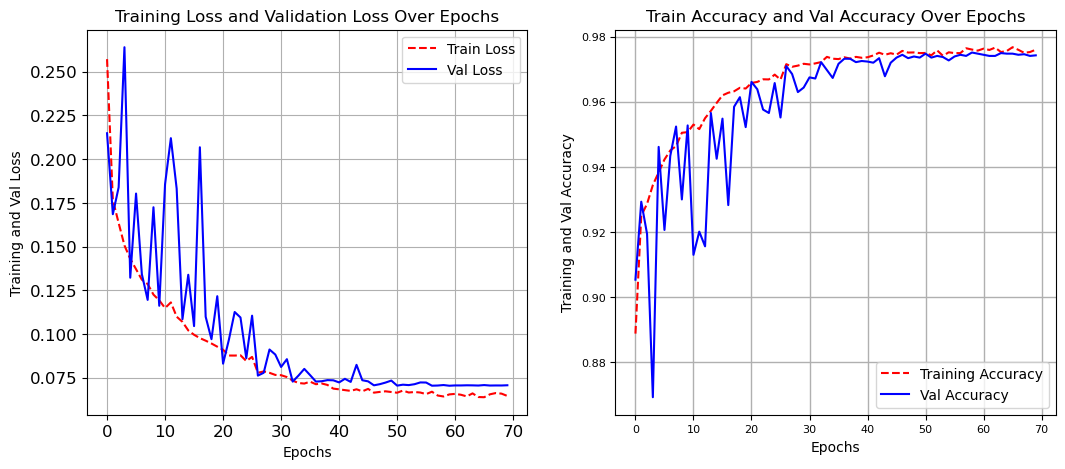

<Figure size 640x480 with 0 Axes>

In [100]:
G9_functions.plot_learning_curves({'best_model':history_best_model})
plt.savefig("Learning_curves_Best_Transformer_Model.png")

The learning curves show appear to follow each other for both the training and validation datasets. The validation loss and accuracy appears to be more variable particualrly in the first 50 epochs. The learning curves do not appear to have plataeud meaning that the training was likely prematurely stopped. 

In [101]:
model_file_path = "Snoring_Binary_Transformer_Model" #model file path
best_transformer_model.save(model_file_path,save_format="tf")

INFO:tensorflow:Assets written to: Snoring_Binary_Transformer_Model\assets


INFO:tensorflow:Assets written to: Snoring_Binary_Transformer_Model\assets


The final trained model shows minor overfitting of the transformer model, however overall it appears satisfactory. 

### Choosing a threshold

In this section we want to determine if a threshold of 0.5 is adequate. To do this the precision and recall curves will be examined for the validation dataset.

In [109]:
y_proba_val = best_transformer_model.predict(X_val_100[:,:,:-1])

180/180 [==============================] - 4s 23ms/step


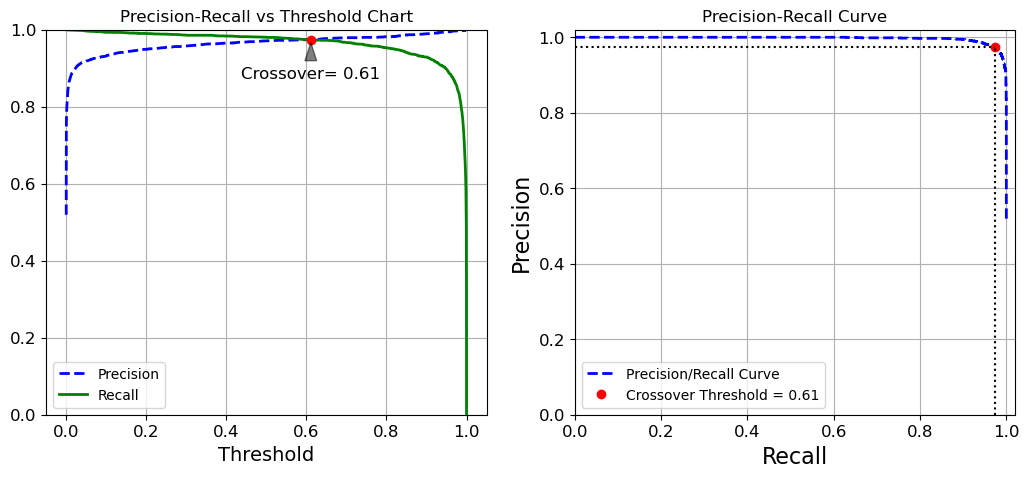

In [111]:
G9_functions.precision_recall_threshold_charts(y_val_100_B,y_proba_val,crossover=True)

The precision-recall curves for the validation dataset crossover when the threshold is equal to 0.61. The aim is to limit false positives or increase precision so having a slightly higher threshold may prove more valuable. Using a threshold of 0.6 might be better suited.

# Performance Metrics for the best transformer model

In [112]:
y_proba_test = best_transformer_model.predict(X_test_100[:,:,:-1])
threshold=0.6
y_pred_test =(y_proba_test >= threshold).astype(int)

240/240 [==============================] - 6s 23ms/step


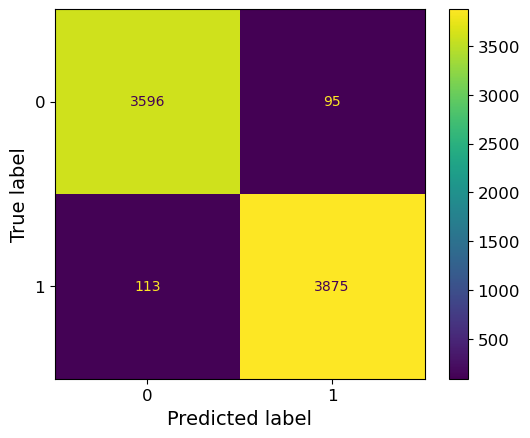

In [116]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report, precision_recall_curve, confusion_matrix,precision_score, recall_score
cm_fig=ConfusionMatrixDisplay(confusion_matrix(y_test_100_B,y_pred_test))
cm_fig.plot()

The CM shows that the model typically corretly classifies the label of each sequence. The model has more false negatives than false posistives.

In [117]:
from sklearn.metrics import classification_report
print(classification_report(y_test_100_B,y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3691
           1       0.98      0.97      0.97      3988

    accuracy                           0.97      7679
   macro avg       0.97      0.97      0.97      7679
weighted avg       0.97      0.97      0.97      7679



The CM and classification report show that the model has an accuracy of **97%** on the test dataset and a precsion of **98%**. These results are highly promising.

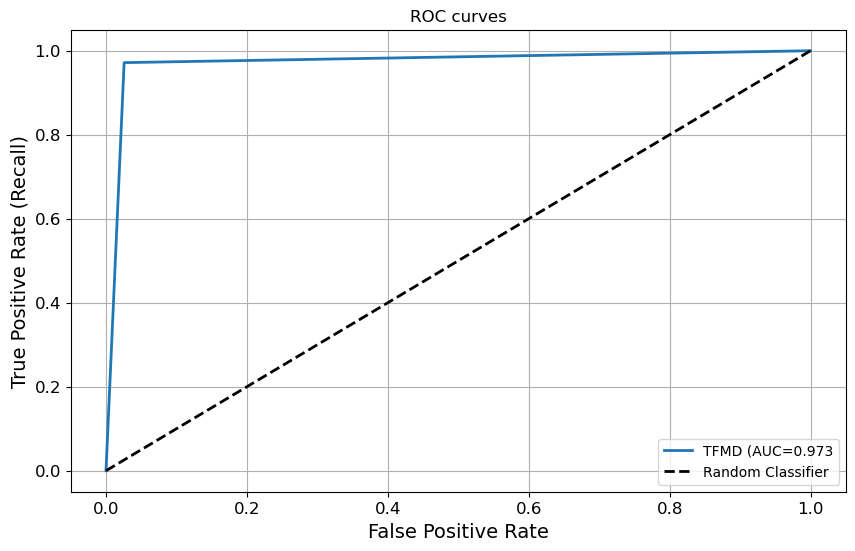

In [120]:
G9_functions.plot_roc_curves(y_test_100_B, {'TFMD':y_pred_test})